##### Viscoplastic ice shelf

## Problem description

The semi-confined ice shelf in this problem flows left-to-right, and encounters marginal resistance only within the final 200 meters of the domain (see the first figure below). When modeling viscous vertical deflection of the system, we find that shear stresses produced by the near-terminus marginal resistance result in rumples which eventually explode and crash the system. Our goal is to produce a plastic deflection which "corrects" the unphysically large viscous deflection. 

## Governing equations

Consider a 2D floating ice shelf, flowing viscously in accordance with the SSA, with depth-averaged velocity $u$ and net depth-integrated stress of $H\overline{\sigma}$, with a viscous deflection $\eta$ and bending moment $M$ resulting in a nonzero height above buoyancy, $h_{ab}$. The shelf will melt backward from the front at exactly the flow rate, which will save us having to track the ice front progression. At each timestep, the shelf obeys the equations below, presented in [Macayeal et al. (2021)](https://www.cambridge.org/core/journals/journal-of-glaciology/article/treatment-of-iceshelf-evolution-combining-flow-and-flexure/AD266BB055752B4DC817FEAAA86363A3):

$$\nabla\cdot\nabla\cdot \mathbf{M} - \rho_wgh_{ab} + \nabla\nabla\eta:H\overline{\boldsymbol{\sigma}} = 0$$
$$\mathbf{M} + C\nabla\nabla\dot{\eta} + Ctr(\nabla\nabla\dot{\eta})\mathbf{I}= 0$$

where I've defined the flexural viscosity $C := \frac{\nu H^3}{6}$. The first equation is the balance of forces in a flowing, viscously-flexing medium, and the second represents the constitutive relation for a material in viscous flexure.

## Solution strategy

### (1) Solve the initial moment-deflection problem

We will first model the system toward steady state geometry and velocity using functionality from icepack, and then solve the above equations iteratively from that steady-state starting point. Let superscripts denote the solution at a given timestep. Then the $t$th solution will be approximated by solving for $M$ and the present rate of viscous deflection, $\dot{\eta}$:

$$\nabla\cdot\nabla\cdot\mathbf{M}^{(t)} - \rho_wg\left(h_{ab}^{(t - 1)} + \dot{\eta}^{(t)}\Delta t\right) + \nabla\nabla\left(\eta^{(t - 1)} + \dot{\eta}^{(t)}\Delta t\right):H\overline{\boldsymbol{\sigma}} = 0$$
$$\mathbf{M}^{(t)} + C\nabla\nabla\dot{\eta}^{(t)} + Ctr(\nabla\nabla\dot{\eta}^{(t)})\mathbf{I} = 0$$

### (2) Adjust the bending moment solution

We will additionally constrain the system so that second invariant, $J_{II}$, of the bending moment is bounded above by some critical value $M_c$. To do this, we define an adjusted bending moment, $\mathbf{M}^*$, such that $J_{II}(\mathbf{M} + \mathbf{M^*}) \leq M_c$. We construct $\mathbf{M}^*$ by defining the scalar $k = k(x, y)$ such that that 

$$k = \begin{cases} 0 & J_{II}(\mathbf{M}) \leq M_c\\
\frac{M_c}{J_{II}(\mathbf{M})} - 1 & J_{II}(\mathbf{M}) > M_c
\end{cases}$$

and define $\mathbf{M}^* := k\mathbf{M}$. It follows from our definition of $k$ that $-1 < k \leq 0$, and so each (nonzero) component of $\mathbf{M}^*$ has the opposite sign of its counterpart in $\mathbf{M}$. In this sense, $\mathbf{M}^*$ "reflects" the moment tensor - a property that is (hopefully??) going to be useful in producing plastic deflections which counterbalance the viscous deflections calculated above. 

### (3) Calculate the plastic deflections

Given this adjusted moment $M^*$, we finally determine $\dot{\eta}^*$, the deflection rate consistent with $M^*$ given the governing equations above. That is, we now solve the system 

$$\nabla\cdot\nabla\cdot \mathbf{M}^* - \rho_wgh_{ab} + \nabla\nabla\eta:H\overline{\boldsymbol{\sigma}} = 0$$
$$\mathbf{M}^* + C\nabla\nabla\dot{\eta}^* + Ctr(\nabla\nabla\dot{\eta}^*)\mathbf{I}= 0$$

Here, the $t$th solution is obtained by finding $\dot{\eta}^{*(t)}$ such that 

$$\nabla\cdot\nabla\cdot\mathbf{M}^{*(t)} - \rho_wg\left(h_{ab}^{(t - 1)} + \dot{\eta}^{*(t)}\Delta t\right) + \nabla\nabla\left(\eta^{(t - 1)} + \dot{\eta}^*\Delta t\right):H\overline{\boldsymbol{\sigma}} = 0$$
$$\mathbf{M}^{*(t)} + C\nabla\nabla\dot{\eta}^{*(t)} + Ctr(\nabla\nabla\dot{\eta}^{*(t)})\mathbf{I} = 0$$

The only unknown in these equations is $\dot{\eta}^{*(t)}$, since $M^{*(t)}$ has already been calculated as described above, and $\eta^{(t - 1)}$ and $h_{ab}^{(t - 1)}$ are known from the previous timestep. 

### (4) Postprocessing

We calculate the net deflection, $\eta$, as the sum of the viscous and plastic deflections $\eta_\nu + \eta_p$. We update the surface and basal elevations $s$  $b$, and then advect all quantities along with flow before beginning the next iteration. To solve the advection problems we use [TransportEquation and TransportSolver](https://github.com/chrismiele/weird_flex/blob/main/flow/transport_solver_1D.ipynb), which will soon be incorporated into icepack.

## Variational form

Let $\vartheta = \vartheta(x, y)$ and $\boldsymbol{\varphi} = \boldsymbol{\varphi}(x, y)$ be arbitrary scalar and tensor functions on the domain $\Omega$. It can be derived that the weak forms of the two steps above are (excluding boundary terms):

### (1) Initial deflection problem

$$-\int_\Omega\nabla\cdot\mathbf{M}^{(t)}\cdot\nabla\vartheta - \int_\Omega\vartheta\rho_wg\dot{\eta}^{(t)}\Delta t - \int_\Omega\vartheta\nabla(\dot{\eta}^{(t)}\Delta t)\cdot\nabla\cdot H\overline{\boldsymbol{\sigma}} = \int_\Omega\vartheta\rho_wgh_{ab}^{(t - 1)} + \int_\Omega\nabla\eta^{(t - 1)}\cdot(\nabla\cdot\left(H\overline{\sigma}\vartheta)\right)$$

$$\int_\Omega\mathbf{M}^{(t)}:\boldsymbol{\varphi} - \int_\Omega\nabla\dot{\eta}^{(t)}\cdot\nabla\cdot C\boldsymbol{\varphi} - \int_\Omega\nabla\dot{\eta}\cdot\nabla\cdot Ctr(\boldsymbol{\varphi})\mathbf{I} = 0$$

### (2) Adjusted deflection problem 

$$-\int_\Omega\nabla\cdot\mathbf{M}^{*(t)}\cdot\nabla\vartheta - \int_\Omega\vartheta\rho_wg\dot{\eta}^{*(t)}\Delta t - \int_\Omega\vartheta\nabla(\dot{\eta}^{*(t)}\Delta t)\cdot\nabla\cdot H\overline{\boldsymbol{\sigma}} = \int_\Omega\vartheta\rho_wgh_{ab}^{(t - 1)} + \int_\Omega\nabla\eta^{(t - 1)}\cdot(\nabla\cdot\left(H\overline{\sigma}\vartheta)\right)$$

$$\int_\Omega\mathbf{M}^{*(t)}:\boldsymbol{\varphi} - \int_\Omega\nabla\dot{\eta}^{*(t)}\cdot\nabla\cdot C\boldsymbol{\varphi} - \int_\Omega\nabla\dot{\eta}^*\cdot\nabla\cdot Ctr(\boldsymbol{\varphi})\mathbf{I} = 0$$

## Boundary conditions

We consider the flexure associated with the buoyancy moment of the terminal cliff, as explored by [Reeh (1968)](https://www.cambridge.org/core/journals/journal-of-glaciology/article/on-the-calving-of-ice-from-floating-glaciers-and-ice-shelves/0E16F201FB4FF676826078C7C5F487DE). The boundary conditions for this problem are below:

- At the upstream boundary (to the left, denoted Boundary 1), assume that grounding line acts as a hinge, permitting neither deflection nor bending. Then $\eta_1^{(t)} = M_1^{(t)} = 0$ at every timestep.
- At the downstream boundary (the cliff to the right, denoted Boundary 2), we can impose a no-shear condition, so that either spatial derivative of any component of $\mathbf{M}$ is zero on $\Gamma_2$. This is enforced by keeping the boundary term

$$\int_{\Gamma_1}\varphi\left(M^{(t)}\right)' = 0$$

- On the right boundary, $M_2^{(t)} = -\frac{1}{12}\rho_igH^3(2\varrho^2 - 3\varrho + 1)$, where $\varrho$ is the proportion of ice thickness below the waterline [(Lipovsky, 2020)](https://tc.copernicus.org/articles/14/1673/2020/). Note that this proportion is generally not equal to $\frac{\rho_i}{\rho_w}$, but instead will vary with time, as the terminus of the shelf will deflect downward from its equilibrium position. This final boundary condition is enforced by adding the boundary term

$$
\int_{\Gamma_2}\vartheta M^{(t)} = -\int_{\Gamma_2}\vartheta\frac{1}{12}\rho_igH^3(2\varrho^2 - 3\varrho + 1)
$$

## Solution options

We can include or leave out the plastic correction term

In [1]:
plastic = True #if False, solves the viscous deflection problem only
nx, ny = 200, 200 #grid resolution (m)
T = 273.14 #temperature (K); freezing is 273.15
M_crit = 5e6 #critical moment threshold for plastic deflection
coeff = 0.00 #friction coefficient. Value from shared simulations is 0.05

In [2]:
saved_arrays_path = '/home/firedrake/H3F/numpy_arrays/' #the path where any existing steady-state flow solutions have already been saved
transport_solver_path = '/home/firedrake/H3F/notebooks/flow/' #where the "transport_solver" module can be imported from
figures_path = '/home/firedrake/H3F/figures/marginal_rumples/' #where figures will be saved

## Imports

In [3]:
# %%capture

from firedrake import *
import icepack
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors
norm = colors.TwoSlopeNorm(vcenter = 0)
import numpy as np
from operator import itemgetter
import os
import tqdm

# !pip install import_ipynb #this block is to allow importing transport_solver, which is not yet a part of icepack
import import_ipynb
os.chdir(transport_solver_path) #location of the transport solver notebook
from transport_solver import TransportEquation, TransportSolver

importing Jupyter notebook from transport_solver.ipynb


## Material parameters

In [4]:
ρ_i = 917 #density of ice (kg/m^3)
ρ_w = 1024 #density of seawater
ϱ = ρ_i/ρ_w #density ratio
g = 9.81 #gravitational constant (N/kg)
H_gl = 500 #grounding line thickness in meters
year = icepack.constants.year #number of seconds in a year
ν_f = 1e14/year #flow viscosity in Pa yr
glen_exponent = 3 #set to 1 or 3 only. Value of A not explored for other n

u_gl = 200 #grounding line velocity boundary condition in meters per year

A_0 = icepack.rate_factor(Constant(T)) if glen_exponent == 3 else 1/(ν/1e6) #make A consistent with ν for n = 1
A = A_0

## Meshing 

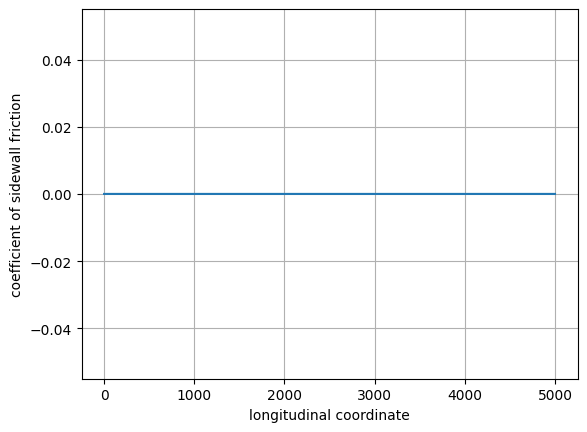

In [5]:
nx, ny = nx, ny #number of nodes
Lx, Ly = 5000, 5000 #length of domain
mesh = RectangleMesh(nx, ny, Lx, Ly, name = f'my_mesh_{nx}_{T}') #identify mesh by resolution and temperature

Δt = 1/20 #timestep 
num_years = 0 #choose how many years to model
num_timesteps = int(num_years/Δt) + 1 #number of timesteps

Q = FunctionSpace(mesh, 'CG', 3)
S = TensorFunctionSpace(mesh, 'CG', 3)
QS = Q*S #mixed function space for (η, M)

η_, M_ = TrialFunctions(QS) #trial functions for the deflection or rate and moment
ϑ, φ = TestFunctions(QS) #test functions
q = Function(QS) #q = (η solution, M solution)

η = Function(Q)

V = VectorFunctionSpace(mesh, 'CG', 3)
u_trial = TrialFunction(V) #trial function for the velocity
v = TestFunction(V) #test function for velocity

x, y = SpatialCoordinate(mesh)
X = np.arange(0, Lx, 1) #for plotting longitudinal profiles
X = np.array([(k, Ly/2) for k in X])

detach, δ = 8.0*Lx/10, Lx/5
friction = coeff*(0.5*cos(pi*(x - detach)/δ) + 0.5)
friction = conditional(x > detach + δ, 0, friction)
friction = Function(Q).project(conditional(x < detach - δ, 0, friction))

friction = Function(Q).project(Constant(coeff)) #for simpler problems

plt.figure()
plt.plot(friction.at(X, tolerance = 1e-10))
plt.ylabel('coefficient of sidewall friction')
plt.xlabel('longitudinal coordinate')
plt.grid()

## Initialize SSA solver and spin up to steady state (or load saved geometry)

In [6]:
#####################################
######################################
### initialize values to be solved ###
######################################
######################################

os.chdir(saved_arrays_path) #location of the transport solver notebook

H_0 = Function(Q).project(Constant(H_gl)) #initial thickness
s_0 = Function(Q).project((1 - ϱ)*H_0) #initial surface elevation

ρ_I, ρ_W = ρ_i/1e6/year**2, ρ_w/1e6/year**2 #put into icepackese
G = g*year**2

def gravity(**kwargs): #see RHS of Eq. 44 in MacAyeal et al. (2021)
    u, H, s = itemgetter('velocity', 'thickness', 'surface')(kwargs)
    return -0.5* ρ_I*G*inner(grad(H**2), u) + 0.5*ρ_W*G*inner(grad((s - H)**2), u)

def terminus(**kwargs): #see Eq. 45 from MacAyeal et al. (2021)
    u, H, s = itemgetter('velocity', 'thickness', 'surface')(kwargs)
    mesh = u.ufl_domain()
    ν = FacetNormal(mesh)
    return 0.5*ρ_I*G*H**2*inner(u, ν) - 0.5*ρ_W*G*(s - H)**2*inner(u, ν)

from icepack.constants import glen_flow_law as n
# from icepack.models.viscosity import viscosity_depth_averaged

def effective_viscosity(**kwargs): #also define a function that returns the effective viscosity
    n = 3
    u = itemgetter('velocity')(kwargs)
    ε = sym(grad(u))
    ε_min = Constant(kwargs.get('strain_rate_min', icepack.constants.strain_rate_min))
    ε_e = icepack.models.viscosity._effective_strain_rate(ε, ε_min)
    ν = 1/2*A_0**(-1/n)*ε_e**(1/n - 1) #effective viscosity in MPa*yrs
    return ν*1e6 #return ν in units of Pa*yrs

opts = {
    'dirichlet_ids': [1], #boundaries are labeled (1, 2, 3, 4) = (upstream, downstream, left, right)
    'side_wall_ids': [3, 4],
    'ice_front_ids': [2],
    }

flow_model = icepack.models.IceShelf(gravity = gravity, terminus = terminus) #model is icepack's SSA, but with our own physics
flow_solver = icepack.solvers.FlowSolver(flow_model, **opts)

In [7]:
try: #load stead state velocity and thickness profile, if this has already been saved:
    
    with CheckpointFile(f"checkpoint_file_{nx}_{T}.h5", 'r') as afile:
        mesh = afile.load_mesh(f'my_mesh_{nx}_{T}')
        s_0 = afile.load_function(mesh, f'surface_{nx}_{T}')
        H_0 = afile.load_function(mesh, f'thickness_{nx}_{T}')
        u_0 = afile.load_function(mesh, f'velocity_{nx}_{T}')

    s_0 = Function(Q).project(s_0)
    H_0 = Function(Q).project(H_0)
    u_0 = Function(V).project(u_0)
    
    u_0 = flow_solver.diagnostic_solve(velocity = u_0, side_friction = friction, 
                                     thickness = H_0, surface = s_0, fluidity = Constant(A_0))
    
    b_0 = Function(Q).project(-ϱ*H_0) #initial basal elevation
    
    ε = Function(S).project(sym(grad(u_0))) #strain rate tensor
    ν = Function(Q).project(effective_viscosity(velocity = u_0)) #effective viscosity
    ν_f0 = Function(Q).project(effective_viscosity(velocity = u_0))
    τ = Function(S).project(2*ν*ε) #deviatoric stress tensor
    P = -tr(τ) + 1/2*ρ_i*g*H_0 #depth-averaged pressure
    σ = Function(S).project(τ - P*Identity(2)) #depth-averaged net stress tensor

except:

###############################
###############################
### spin up to steady state ###
###############################
###############################

    residence_time = int(Lx/u_gl) #estimated number of years for grounding line ice to reach the terminus
    dt = 1/10 #set the timestep to one tenth of a year
    u_0 = Function(V).project(as_vector((u_gl, 1e-50)))
    
    for step in tqdm.trange(int(residence_time/dt)):
    # for step in tqdm.trange(1):
        
        u_0 = flow_solver.diagnostic_solve(velocity = u_0, side_friction = friction,
                                         thickness = H_0, surface = s_0, fluidity = Constant(A_0))
        H_0 = flow_solver.prognostic_solve(dt, thickness = H_0, velocity = u_0,
                                         thickness_inflow = H_0, accumulation = Constant(0))
        s_0 = Function(Q).project((1 - ϱ)*H_0) #initial surface elevation
    
    s_0 = Function(Q, name = f'surface_{nx}_{T}').project(s_0)
    H_0 = Function(Q, name = f'thickness_{nx}_{T}').project(H_0)
    u_0 = Function(V, name = f'velocity_{nx}_{T}').project(u_0)
    b_0 = Function(Q).project(-ϱ*H_0) #initial basal elevation

    with CheckpointFile(f'checkpoint_file_{nx}_{T}.h5', 'w') as afile:
        afile.save_mesh(mesh)  # optional
        afile.save_function(s_0)
        afile.save_function(H_0)
        afile.save_function(u_0)

## Plot the initial steady-state geometry

Text(0, 0.5, 'lateral coordinate (m)')

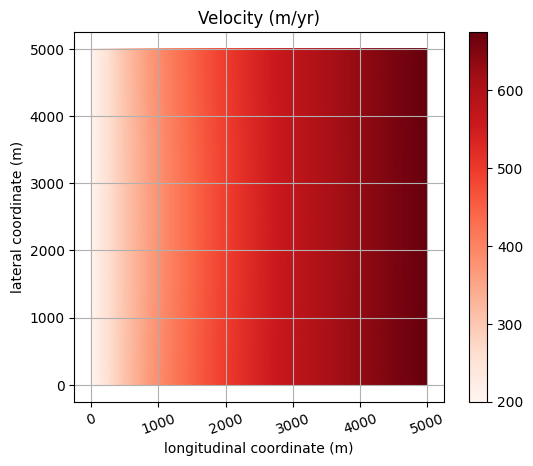

In [8]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
plot = tripcolor(u_0, axes = ax, cmap = 'Reds')#, vmin = 30, vmax = 100)
plt.colorbar(plot)
plt.xticks(range(0, Lx + 1, 1000), rotation = 20)
plt.title('Velocity (m/yr)')
plt.xlabel('longitudinal coordinate (m)')
plt.grid()
plt.ylabel('lateral coordinate (m)')

In [9]:
####################################
####################################
### initialize remaining solvers ###
####################################
####################################

nonconservative_transport_model = TransportEquation(field_name = 'field', conservative = False) #for nonconservative advection
nonconservative_transport_solver = TransportSolver(nonconservative_transport_model) #e.g., η, eventually damage

H = H_0.copy(deepcopy = True)
s = s_0.copy(deepcopy = True)
b = b_0.copy(deepcopy = True)
u = u_0.copy(deepcopy = True)

if plastic:
    path = figures_path + f'viscoplastic/{nx}_{T}'
else:
    path = figures_path + f'viscous/{nx}_{T}'

try:
    os.chdir(path)
except:
    os.mkdir(path)
    os.chdir(path)

In [10]:
os.getcwd()

'/home/firedrake/H3F/figures/marginal_rumples/viscoplastic/200_273.14'

## Solve with firedrake

### 1) Viscous step 

Define

$$a := -\int_\Omega\nabla\cdot\mathbf{M}^{(t)}\cdot\nabla\vartheta - \int_\Omega\vartheta\rho_wg\dot{\eta}_\nu^{(t)}\Delta t - \int_\Omega\vartheta\nabla(\Delta\dot{\eta}_\nu^{(t)}\Delta t)\cdot\nabla\cdot H\overline{\boldsymbol{\sigma}} + \int_\Omega\mathbf{M}^{(t)}:\boldsymbol{\varphi} - \int_\Omega\nabla\dot{\eta}_\nu^{(t)}\cdot\nabla\cdot C\boldsymbol{\varphi} - \int_\Omega\nabla\dot{\eta}_\nu\cdot\nabla\cdot Ctr(\boldsymbol{\varphi})\mathbf{I}$$

$$L := \int_\Omega\vartheta\rho_wgh_{ab}^{(t - 1)} + \int_\Omega\nabla\eta^{(t - 1)}\cdot(\nabla\cdot\left(H\overline{\sigma}\vartheta)\right)$$

and again solve $a = L$ alongside the appropriate boundary conditions. 

### 2) Plastic correction

Etc.

In [11]:
for step in tqdm.trange(num_timesteps):

    #########################
    #########################
    ### obtain flow field ###
    #########################
    #########################
    
    u = flow_solver.diagnostic_solve(velocity = u, side_friction = friction, 
                             thickness = H, surface = s)
    b = flow_solver.prognostic_solve(Δt, thickness = b, velocity = u,
                                     thickness_inflow = b, accumulation = Constant(0))
    s = flow_solver.prognostic_solve(Δt, thickness = s, velocity = u,
                                     thickness_inflow = s, accumulation = Constant(0))     

    s = Function(Q).project(s)
    H = Function(Q).project(s - b) #initial basal elevation
    ε = Function(S).project(sym(grad(u))) #strain rate tensor

    ν = effective_viscosity(velocity = u) #effective viscosity
    τ = Function(S).project(2*ν*ε) #deviatoric stress tensor
    P = -tr(τ) + 1/2*ρ_i*g*H #depth-averaged pressure
    σ = τ - P*Identity(2) #depth-averaged net stress tensor

    h_ab = Function(Q).project(s - (1 - ρ_i/ρ_w)*H)
    ϱ = Function(Q).project(1 - s/H)

    C = Function(Q).project(1/6*ν*H**3)

    ######################
    ######################
    ### flex the shelf ###
    ######################
    ######################
    
    M_term = Function(Q).project(-1/12*ρ_i*g*H**3*(2*ϱ**2 - 3*ϱ + 1))
    M_term = Function(S).project(as_tensor(([M_term, 0], [0, 0])))
    M_term = DirichletBC(QS.sub(1), M_term, 2)
    inflow_ids = [1]
    M_gl = DirichletBC(QS.sub(1), 0*Identity(2), inflow_ids)
    η_gl = DirichletBC(QS.sub(0), 0, inflow_ids)
    
    Δη_ν, Δη_p = Function(Q), Function(Q)

    a = -dot(div(M_), grad(ϑ))*dx - ϑ*ρ_w*g*η_*Δt*dx - dot(grad(η_*Δt), div(ϑ*H*σ))*dx
    a += inner(M_, φ)*dx - dot(grad(η_), div(C*φ))*dx - dot(grad(η_), div(C*tr(φ)*Identity(2)))*dx
    L = ϑ*ρ_w*g*(h_ab)*dx + dot(grad(η), div(ϑ*H*σ))*dx

    # a += 1/2*(1e10)**2*grad(M_[0, 0])[1]*grad(φ[0, 0])[1]*(ds + dx)
    a += 1/2*(1e10)**2*(φ[0, 1]*M_[0, 1] + φ[1, 0]*M_[1, 0] + φ[1, 1]*M_[1, 1])*(dx + ds) #M_xy = M_yx = 0
    a += 1/2*1e10**2*grad(ϑ)[1]*grad(η_)[1]*(ds + dx)

    solve(a == L, q, bcs = [η_gl, M_gl, M_term])

    Δη_ν.project(q[0]*Δt)
    η.project(η + Δη_ν)
    s = Function(Q).project(s + Δη_ν)
    b = Function(Q).project(b + Δη_ν)
    M_e = Function(Q).project(sqrt(1/2*(q[1]**2 + q[4]**2) + q[2]**2 + q[3]**2)) #the "effective" moment
    k = Function(Q).project(conditional(M_e > M_crit, M_crit/M_e - 1, 0))
    M_star = Function(S).project(as_tensor(([k*q[1], k*q[2]], [k*q[3], k*q[4]]))) 
    M_original = Function(S).project(as_tensor(([q[1], q[2]], [q[3], q[4]])))
    
    if plastic:

        viscous_zone = Function(Q).project(conditional(M_e < M_crit, 1, 0)) #identifies the zone where no plastic correction is required
        plastic_zone = Function(Q).project(conditional(M_e >= M_crit, 1, 0)) #and the complement of that zone
        internal_boundary = Function(Q).project(conditional(And(M_e >= M_crit, M_e <= M_crit), 1, 0))
        
        a = -ϑ*ρ_w*g*η_*Δt*dx - dot(grad(η_*Δt), div(ϑ*H*σ))*dx
        a += -dot(grad(η_), div(C*φ))*dx - dot(grad(η_), div(C*tr(φ)*Identity(2)))*dx
        L = ϑ*ρ_w*g*(h_ab)*dx  - inner(grad(grad(η)), H*ϑ*σ)*dx # + dot(grad(η), div(ϑ*H*σ))*dx
        L += dot(div(M_star), grad(ϑ))*dx - inner(M_star, φ)*dx
        
        a += 1/2*(1e10)**2*ϑ*η_*viscous_zone*(dx + ds) #plastic deflection should be zero (or otherwise constrained??) within the "viscous_zone"
        # L += 1/2*(1e10)**2*ϑ*-Δη_ν/Δt*viscous_zone*(dx + ds) #...other possibilities exist too...
        
        a += 1/2*(1e10)**2*inner(φ, M_)*(dx + ds) #We still have to solve for M, but may as well constrain it to be zero
        # a += 1/2*(1e10)**2*(φ[0, 1]*M_[0, 1] + φ[1, 0]*M_[1, 0])*(dx + ds) #M_xy = M_yx = 0
        a += 1/2*1e10**2*grad(ϑ)[1]*grad(η_)[1]*(ds + dx) #η does not vary in y 

        solve(a == L, q, bcs = [η_gl, DirichletBC(QS.sub(1), 0*Identity(2), (1, 2, 3, 4))])
        
        Δη_p.project(q[0]*Δt)
        η.project(η + Δη_p)
        s = Function(Q).project(s + Δη_p)
        b = Function(Q).project(b + Δη_p)

    η = nonconservative_transport_solver.prognostic_solve(Δt, field = η, velocity = u, field_inflow = η,
                                                               field_accumulation = Constant(0))

    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    plot = tripcolor(η, axes = ax, cmap = 'seismic', vmin = -1, vmax = 1)
    plt.colorbar(plot)
    plt.xticks(range(0, Lx + 1, 1000), rotation = 20)
    plt.xlabel('longitudinal coordinate (m)')
    plt.grid()
    plt.ylabel('lateral coordinate (m)')
    plt.savefig(f'{step}')
    plt.title(f'$t$ = {step*Δt:.2f} years', fontsize = 16)
    plt.tight_layout()
    plt.close()

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:20<00:00, 200.37s/it]


# Plot results

Text(0, 0.5, 'lateral coordinate (m)')

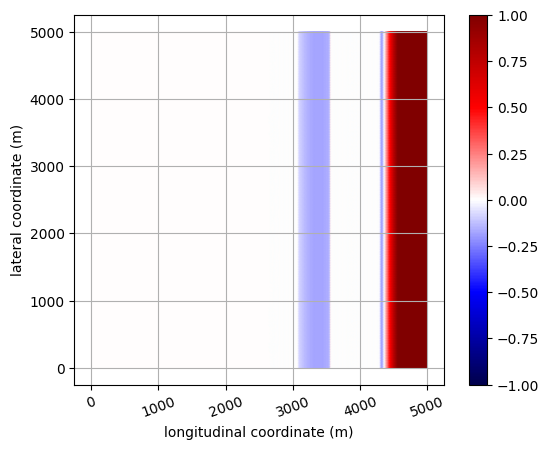

In [12]:
M_sum = Function(S).project(M_star + M_original) #the tensor whose second invariant should be bounded above by M_crit
J_ii = Function(Q).project(sqrt(1/2*(M_sum[0, 0]**2 + M_sum[1, 1]**2) + M_sum[0, 1]**2 + M_sum[1, 0]**2)) #the second invariant itself

fig, ax = plt.subplots()
ax.set_aspect('equal')
plot = tripcolor(Δη_p, axes = ax, cmap = 'seismic', vmin = -1, vmax = 1) #ideally this shouldn't look totally unhinged
# plot = tripcolor(Function(Q).project(grad(grad(Δη_ν))[0, 0]), axes = ax, cmap = 'seismic')#, vmin = -M_crit, vmax = 3*M_crit) #on this scale, we shouldn't see any red
plt.colorbar(plot)
plt.xticks(range(0, Lx + 1, 1000), rotation = 20)
plt.xlabel('longitudinal coordinate (m)')
plt.grid()
plt.ylabel('lateral coordinate (m)')

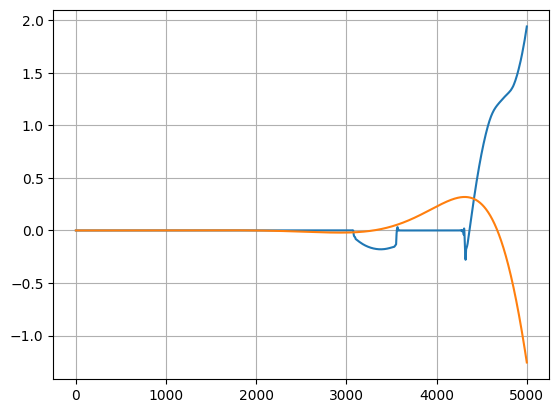

In [13]:
Δη_p_profile = Δη_p.at(X, tolerance = 1e-10)
Δη_ν_profile = Δη_ν.at(X, tolerance = 1e-10)
plt.figure()
plt.plot(Δη_p_profile)
plt.plot(Δη_ν_profile)
plt.grid()